<a href="https://colab.research.google.com/github/daaariada/MAI_ML_2023/blob/main/Coursework_ShadaiMukhanovSmirnov_107.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Работу выполнили:

Шадай Дарья М8О-107М-23

Муханов Дмитрий М8О-107М-23

Смирнов Олег М8О-107М-23

За основу выбран датасет Laptop Price (https://www.kaggle.com/datasets/muhammetvarl/laptop-price)

# Описание датасета

Датасет представлен следующими колонками:



1. Company - String - Производитель ноутбука
2. Product - String - Бренд и модель
3. TypeName - String - Тип ноутбука (Notebook, Ultrabook, Gaming, etc.)
4. Inches - Numeric - Диагональ
5. ScreenResolution - String - Разрешение экрана
6. Cpu- String - CPU
7. Ram - String - RAM
8. Memory - String - HDD/SSD
9. GPU - String - GPU
10. OpSys - String - Операционная система
11. Weight - String - Вес
12. Price_euros - Numeric - Стоимость ноутбука в евро



In [ ]:
import pandas as pd
import numpy as np
import regex as re
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

seed = 42

In [ ]:
# Подключение к гугл-диску, на котором лежит датасет
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Выводим первые несколько строк датасета
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/laptop_price.csv", encoding='latin1')
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


Числовых колонки всего две — Inches и Price_euros. Для простоты дальнейшей обработки, попробуем перевести и другие колонки в числовые.



In [ ]:
df.describe()

,laptop_ID,Inches,Price_euros
count,1303.000000,1303.000000,1303.000000
mean,660.155794,15.017191,1123.686992
std,381.172104,1.426304,699.009043
min,1.000000,10.100000,174.000000
25%,331.500000,14.000000,599.000000
50%,659.000000,15.600000,977.000000
75%,990.500000,15.600000,1487.880000
max,1320.000000,18.400000,6099.000000


# Чистим датасет

Для простоты, переведем названия колонок в нижний регистр и переименуем колонку 'price_euros' в 'price':

In [ ]:
df = df.rename(columns=str.lower)
df = df.rename(columns={'price_euros':'price'})
df.columns

Index(['laptop_id', 'company', 'product', 'typename', 'inches',
       'screenresolution', 'cpu', 'ram', 'memory', 'gpu', 'opsys', 'weight',
       'price'],
      dtype='object')

## Рассмотрим laptop_id


In [ ]:
df['laptop_id']

0          1
1          2
2          3
3          4
4          5
        ... 
1298    1316
1299    1317
1300    1318
1301    1319
1302    1320
Name: laptop_id, Length: 1303, dtype: int64

Можно увидеть, что в конце laptop_id отличается от индекса. Найдем, с чего началась путаница:

In [ ]:
ind=0
for i in df['laptop_id']:
    if ind+1 != i:
        print(i)
        break
    ind+=1

66


In [ ]:
df[df['laptop_id']==66]

,laptop_id,company,product,typename,inches,screenresolution,cpu,ram,memory,gpu,opsys,weight,price
64,66,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.86kg,690.0


In [ ]:
df=df.drop('laptop_id', axis=1)

Начиная с laptop_id = 66, идет несовпадение индекса и laptop_id. Отбросим laptop_id, чтобы не путаться.

## Рассмотрим screenresolution

In [ ]:
df['screenresolution']

0               IPS Panel Retina Display 2560x1600
1                                         1440x900
2                                Full HD 1920x1080
3               IPS Panel Retina Display 2880x1800
4               IPS Panel Retina Display 2560x1600
                           ...                    
1298     IPS Panel Full HD / Touchscreen 1920x1080
1299    IPS Panel Quad HD+ / Touchscreen 3200x1800
1300                                      1366x768
1301                                      1366x768
1302                                      1366x768
Name: screenresolution, Length: 1303, dtype: object

Разделим этот столбец на три: разрешение, тип экрана, наличие тачскрина.

In [ ]:
df['resolution'] = df['screenresolution'].str.extract(r'(\d+x\d+)')
df['screentype'] = df['screenresolution'].replace(r'(\d+x\d+)','',regex=True)
df['screentype'] = df['screentype'].replace(r'(Full HD|Quad HD|Quad HD|\+|/|4K Ultra HD)','',regex=True)
df['screentype']

0       IPS Panel Retina Display 
1                                
2                                
3       IPS Panel Retina Display 
4       IPS Panel Retina Display 
                  ...            
1298     IPS Panel   Touchscreen 
1299     IPS Panel   Touchscreen 
1300                             
1301                             
1302                             
Name: screentype, Length: 1303, dtype: object

In [ ]:
df['touchscreen'] = df['screentype'].str.extract(r'(Touchscreen)')
df['screentype'] = df['screentype'].replace(r'(Touchscreen)','',regex=True)
df['touchscreen'].value_counts()

Touchscreen    192
Name: touchscreen, dtype: int64

In [ ]:
df['touchscreen'] = df['touchscreen'].replace('Touchscreen',1)
df['touchscreen'] = df['touchscreen'].replace(np.nan,0)
df['touchscreen'].value_counts()

0.0    1111
1.0     192
Name: touchscreen, dtype: int64

In [ ]:
df['screentype'].value_counts()

                             549
                             314
IPS Panel                    265
                              75
IPS Panel                     72
IPS Panel Retina Display      17
IPS Panel                     11
Name: screentype, dtype: int64

In [ ]:
df['screentype']=df['screentype'].replace(r' ','',regex=True)
df['screentype'].value_counts()

                         938
IPSPanel                 348
IPSPanelRetinaDisplay     17
Name: screentype, dtype: int64

In [ ]:
df['screentype'] = df['screentype'].replace(r'^\s*$', np.nan, regex=True)
df['screentype'].value_counts()

IPSPanel                 348
IPSPanelRetinaDisplay     17
Name: screentype, dtype: int64

Так как мы разделили колонку screenresolution на три других, можем ее отбросить. Рассмотрим получившиеся колонки:

In [ ]:
df = df.drop('screenresolution', axis=1)
df['resolution'].value_counts()

1920x1080    841
1366x768     308
3840x2160     43
3200x1800     27
2560x1440     23
1600x900      23
2560x1600      6
2304x1440      6
2256x1504      6
1920x1200      5
1440x900       4
2880x1800      4
2400x1600      4
2160x1440      2
2736x1824      1
Name: resolution, dtype: int64

In [ ]:
df['screentype'].value_counts()

IPSPanel                 348
IPSPanelRetinaDisplay     17
Name: screentype, dtype: int64

In [ ]:
df['touchscreen'].value_counts()

0.0    1111
1.0     192
Name: touchscreen, dtype: int64

## Рассмотрим CPU

In [ ]:
df['cpu']

0                       Intel Core i5 2.3GHz
1                       Intel Core i5 1.8GHz
2                 Intel Core i5 7200U 2.5GHz
3                       Intel Core i7 2.7GHz
4                       Intel Core i5 3.1GHz
                        ...                 
1298              Intel Core i7 6500U 2.5GHz
1299              Intel Core i7 6500U 2.5GHz
1300    Intel Celeron Dual Core N3050 1.6GHz
1301              Intel Core i7 6500U 2.5GHz
1302    Intel Celeron Dual Core N3050 1.6GHz
Name: cpu, Length: 1303, dtype: object

Извлечем частоту процессора в отдельную колонку:

In [ ]:
df['cpu_freq'] = df['cpu'].str.extract(r'(\d+(?:\.\d+)?GHz)')
df['cpu_freq'].value_counts()

2.5GHz     290
2.7GHz     165
2.8GHz     165
1.6GHz     133
2.3GHz      86
1.8GHz      78
2.6GHz      76
2GHz        67
1.1GHz      53
2.4GHz      52
2.9GHz      21
3GHz        19
2.0GHz      19
1.2GHz      15
1.44GHz     12
2.2GHz      11
1.5GHz      10
1.3GHz       6
3.6GHz       5
0.9GHz       4
3.1GHz       3
2.1GHz       3
2.50GHz      3
1.9GHz       2
1.60GHz      1
3.2GHz       1
1.0GHz       1
1.92GHz      1
2.70GHz      1
Name: cpu_freq, dtype: int64

Превратим эту колонку в числовую, отбросив GHz:

In [ ]:
df['cpu_freq'] = df['cpu_freq'].str.replace('GHz', '')
df['cpu_freq'] = df['cpu_freq'].astype(float)
df['cpu']= df['cpu'].str.replace(r'(\d+(?:\.\d+)?GHz)', '', regex=True)

## Рассмотрим RAM

Превратим эту колонку в числовую, отбросив GB:

In [ ]:
df['ram'] = df['ram'].str.replace('GB', '')
df['ram'] = df['ram'].astype(int)

## Рассмотрим Price

Заметим, что у нас есть несколько строк с очень высокой ценой относительно других записей. Лучше их убрать.

In [ ]:
df['price'].value_counts().sort_index()

174.0     1
191.9     1
196.0     1
199.0     2
202.9     1
         ..
3975.0    1
4389.0    1
4899.0    1
5499.0    1
6099.0    1
Name: price, Length: 791, dtype: int64

In [ ]:
df = df.drop(df[df['price'] >= 4389.0].index)

In [ ]:
df['price'].value_counts().sort_index()

174.0     1
191.9     1
196.0     1
199.0     2
202.9     1
         ..
3588.8    1
3659.4    1
3890.0    1
3949.4    1
3975.0    1
Name: price, Length: 787, dtype: int64

## Рассмотрим Memory

In [ ]:
df['memory']

0                 128GB SSD
1       128GB Flash Storage
2                 256GB SSD
3                 512GB SSD
4                 256GB SSD
               ...         
1298              128GB SSD
1299              512GB SSD
1300     64GB Flash Storage
1301                1TB HDD
1302              500GB HDD
Name: memory, Length: 1299, dtype: object

In [ ]:
df['memory'].value_counts()

256GB SSD                        411
1TB HDD                          223
500GB HDD                        132
512GB SSD                        117
128GB SSD +  1TB HDD              94
128GB SSD                         76
256GB SSD +  1TB HDD              73
32GB Flash Storage                38
2TB HDD                           16
64GB Flash Storage                15
512GB SSD +  1TB HDD              14
1TB SSD                           12
256GB SSD +  2TB HDD              10
1.0TB Hybrid                       9
256GB Flash Storage                8
16GB Flash Storage                 7
32GB SSD                           6
180GB SSD                          5
128GB Flash Storage                4
512GB SSD +  2TB HDD               3
16GB SSD                           3
512GB Flash Storage                2
1TB SSD +  1TB HDD                 2
256GB SSD +  500GB HDD             2
128GB SSD +  2TB HDD               2
256GB SSD +  256GB SSD             2
512GB SSD +  256GB SSD             1
5

Можно заметить, что запись о памяти ноутбука состоит из объема диска и его вида. Также есть ноутбуки, вмещающие сразу два диска памяти. Разделим колонку memory на четыре колонки: объем памяти 1, тип памяти 1, объем памяти 2, тип памяти 2. Также переведем терабайты в гигабайты.

In [ ]:
df['memory_1']=df['memory']
df['memory_1']=df['memory_1'].str.replace('1.0TB','1TB', regex=True)
df['memory_1']=df['memory_1'].str.replace('1TB','1000GB')
df['memory_1']=df['memory_1'].str.replace('2TB','2000GB')
df['memory_1']=df['memory_1'].str.replace('GB','')
df['memory_1'].value_counts()

256 SSD                         411
1000 HDD                        224
500 HDD                         132
512 SSD                         117
128 SSD +  1000 HDD              94
128 SSD                          76
256 SSD +  1000 HDD              73
32 Flash Storage                 38
2000 HDD                         16
64 Flash Storage                 15
512 SSD +  1000 HDD              14
1000 SSD                         12
256 SSD +  2000 HDD              10
1000 Hybrid                       9
256 Flash Storage                 8
16 Flash Storage                  7
32 SSD                            6
180 SSD                           5
128 Flash Storage                 4
512 SSD +  2000 HDD               3
16 SSD                            3
512 Flash Storage                 2
1000 SSD +  1000 HDD              2
256 SSD +  500 HDD                2
128 SSD +  2000 HDD               2
256 SSD +  256 SSD                2
512 SSD +  256 SSD                1
512 SSD +  512 SSD          

In [ ]:
df['memory2']=df['memory_1'].str.replace(r' ','')
df['memory2'].value_counts()

256SSD                    411
1000HDD                   224
500HDD                    132
512SSD                    117
128SSD+1000HDD             94
128SSD                     76
256SSD+1000HDD             73
32FlashStorage             38
2000HDD                    16
64FlashStorage             15
512SSD+1000HDD             14
1000SSD                    12
256SSD+2000HDD             10
1000Hybrid                  9
256FlashStorage             8
16FlashStorage              7
32SSD                       6
180SSD                      5
128FlashStorage             4
512SSD+2000HDD              3
16SSD                       3
512FlashStorage             2
1000SSD+1000HDD             2
256SSD+500HDD               2
128SSD+2000HDD              2
256SSD+256SSD               2
512SSD+256SSD               1
512SSD+512SSD               1
64FlashStorage+1000HDD      1
1000HDD+1000HDD             1
32HDD                       1
64SSD                       1
128HDD                      1
240SSD    

In [ ]:
memory_1=[]
memory_2=[]
for i in df['memory2']:
    if len(re.findall(r'\+',i))==1: # 2 диска
        one=re.findall(r'(\w+)',i)
        memory_1.append(one[0])
        memory_2.append(one[1])
    else: # 1 диск
        one=re.findall(r'(\w+)',i)
        memory_1.append(one[0])
        memory_2.append('NaN')

memory_1_gb=[]
memory_1_type=[]
for i in memory_1:
    memory_1_type.append(re.findall(r'(\D\w+)',i)[0])
    memory_1_gb.append(re.findall(r'(\d+)',i)[0])

memory_2_gb=[]
memory_2_type=[]
for i in memory_2:
    if i != 'NaN':
        memory_2_type.append(re.findall(r'(\D\w+)',i)[0])
        memory_2_gb.append(re.findall(r'(\d+)',i)[0])
    else:
        memory_2_type.append('NaN')
        memory_2_gb.append(0)

df['memory_1_sto'] = memory_1_gb
df['memory_1_type'] = memory_1_type
df['memory_2_sto'] = memory_2_gb
df['memory_2_type'] = memory_2_type

df['memory_1_sto'] = df['memory_1_sto'].astype(float)
df['memory_2_sto'] = df['memory_2_sto'].astype(float)

df=df.drop(['memory_1','memory2','memory'], axis=1)
df = df.replace({'NaN': np.nan})

## Рассмотрим Weight

In [ ]:
df['weight'].value_counts()

2.2kg     121
2.1kg      58
2.4kg      44
2.3kg      41
2.5kg      37
         ... 
3.8kg       1
1.59kg      1
3.49kg      1
1.55kg      1
4.0kg       1
Name: weight, Length: 179, dtype: int64

In [ ]:
df['weight'].str.contains('kg').sum()

1299

Так как все строки содержат вес в килограммах, можно отбросить "kg" из значений.

In [ ]:
df['weight'] = df['weight'].str.replace('kg','').astype(float)

## Рассмотрим компании, выпускающие CPU и GPU

In [ ]:
df['cpu_brand'] = df['cpu'].str.extract(r'^(\w+)')
df['cpu_brand'].value_counts()

Intel      1236
AMD          62
Samsung       1
Name: cpu_brand, dtype: int64

In [ ]:
df[df['cpu_brand']=='Samsung']

,company,product,typename,inches,cpu,ram,gpu,opsys,weight,price,resolution,screentype,touchscreen,cpu_freq,memory_1_sto,memory_1_type,memory_2_sto,memory_2_type,cpu_brand
1191,Samsung,Chromebook Plus,2 in 1 Convertible,12.3,Samsung Cortex A72&A53,4,ARM Mali T860 MP4,Chrome OS,1.15,659.0,2400x1600,IPSPanel,1.0,2.0,32.0,FlashStorage,0.0,NaN,Samsung


Так как Samsung представлен всего в одном экземпляре, отбросим эту строку:

In [ ]:
df=df.drop(1191)
df['gpu_brand'] = df['gpu'].str.extract(r'^(\w+)')
df['gpu_brand'].value_counts()

Intel     722
Nvidia    396
AMD       180
Name: gpu_brand, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1298 entries, 0 to 1302
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   company        1298 non-null   object 
 1   product        1298 non-null   object 
 2   typename       1298 non-null   object 
 3   inches         1298 non-null   float64
 4   cpu            1298 non-null   object 
 5   ram            1298 non-null   int64  
 6   gpu            1298 non-null   object 
 7   opsys          1298 non-null   object 
 8   weight         1298 non-null   float64
 9   price          1298 non-null   float64
 10  resolution     1298 non-null   object 
 11  screentype     362 non-null    object 
 12  touchscreen    1298 non-null   float64
 13  cpu_freq       1298 non-null   float64
 14  memory_1_sto   1298 non-null   float64
 15  memory_1_type  1298 non-null   object 
 16  memory_2_sto   1298 non-null   float64
 17  memory_2_type  208 non-null    object 
 18  cpu_bran

In [ ]:
df.head()

,company,product,typename,inches,cpu,ram,gpu,opsys,weight,price,resolution,screentype,touchscreen,cpu_freq,memory_1_sto,memory_1_type,memory_2_sto,memory_2_type,cpu_brand,gpu_brand
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,2560x1600,IPSPanelRetinaDisplay,0.0,2.3,128.0,SSD,0.0,NaN,Intel,Intel
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5,8,Intel HD Graphics 6000,macOS,1.34,898.94,1440x900,NaN,0.0,1.8,128.0,FlashStorage,0.0,NaN,Intel,Intel
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U,8,Intel HD Graphics 620,No OS,1.86,575.00,1920x1080,NaN,0.0,2.5,256.0,SSD,0.0,NaN,Intel,Intel
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7,16,AMD Radeon Pro 455,macOS,1.83,2537.45,2880x1800,IPSPanelRetinaDisplay,0.0,2.7,512.0,SSD,0.0,NaN,Intel,AMD
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,2560x1600,IPSPanelRetinaDisplay,0.0,3.1,256.0,SSD,0.0,NaN,Intel,Intel


Датасет готов к дальнейшей работе

In [ ]:
df.to_csv('laptop-clean.csv', index=False)
!cp laptop-clean.csv "/content/drive/MyDrive/Colab Notebooks/"

In [ ]:
df1=pd.read_csv('laptop-clean.csv')
df_clean=df1.copy()

# Анализ данных

In [ ]:
class LaptopPricePrediction:
    def __init__(self, model):
        self.model = model

    def first_view(self, csv_file):
        df = pd.read_csv(csv_file)
        return df.info(), df.describe()

    def data_loader(self, csv_file, encoding):
        dataframe = pd.read_csv(csv_file, encoding=encoding)
        #print("Column names:", dataframe.columns)
        return dataframe

    def cor_mat(self, data_clear):
        # Матрица корреляций
        plt.figure(figsize=(6,5))
        sns.heatmap(data_clear.corr(), cmap="BuPu", annot=True, vmin=-1, vmax=1)
        plt.title('Матрица корреляций')
        plt.show()

    def get_plot(self, data_clear, plot_type):
        # График количество/нечто
        fig, ax = plt.subplots(1, 1, figsize=(8,5))
        sns.histplot(x=plot_type, data=data_clear, ax=ax)
        ax.set_xlabel(plot_type, fontsize=16)
        plt.tight_layout()
        plt.show()

    def get_memory_data(self, data_clear):
        # Емкость основного жесткого диска
        fig, ax  = plt.subplots(figsize=(8,5))
        ax=sns.countplot(x='memory_1_sto', data=data_clear, hue='memory_1_type')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_xlabel('Емкость основного жесткого диска')
        plt.legend(loc='upper left', ncol=1, fontsize=15, fancybox=True, shadow=True, frameon=True)
        plt.show()

        # Емкость дополнительного жесткого диска
        fig, ax  = plt.subplots(figsize=(8,5))
        ax=sns.countplot(x='memory_2_sto', data=data_clear, hue='memory_2_type')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_xlabel('Емкость дополнительного жесткого диска')
        plt.legend(loc='upper left', ncol=1, fontsize=15, fancybox=True, shadow=True, frameon=True)
        plt.show()

    def data_preparing(self, data_clear):
        df = data_clear
        y = df['price']
        X = df.drop('price', axis=1)
        X = X.select_dtypes(include=['number']).values
        y = y.values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = seed)
        return X_train, X_test, y_train, y_test

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        y_pred = self.model.predict(X_test)
        return y_pred

    def visualization(self, y_test, y_pred):
        plt.figure(figsize=(10, 7))
        plt.scatter(y_test, y_pred)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", color="red")
        plt.xlabel('Фактические', weight="bold")
        plt.ylabel('Прогнозируемые', weight="bold")
        plt.grid(color='black', linestyle='--', linewidth=0.2)
        plt.title('Фактические значения vs прогнозируемые значения')
        plt.show()
        mse_rf = mean_squared_error((y_test), (y_pred))
        print("RMSE: {} $ ".format(np.round(np.sqrt(mse_rf)),4))
        print("R2: {:.2f} %".format(np.round(r2_score(y_test, y_pred),4)*100))

In [ ]:
# Использование класса для анализа ноутбуков
laptop_model = LaptopPricePrediction(RandomForestRegressor(n_estimators=100, max_depth=100, max_features=15))
# Загрузка датасета
data_laptop = laptop_model.data_loader("/content/drive/MyDrive/Colab Notebooks/laptop-clean.csv", encoding='latin1')

## Матрица корреляций

<ipython-input-861-6e1476777a89>:17: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data_clear.corr(), cmap="BuPu", annot=True, vmin=-1, vmax=1)


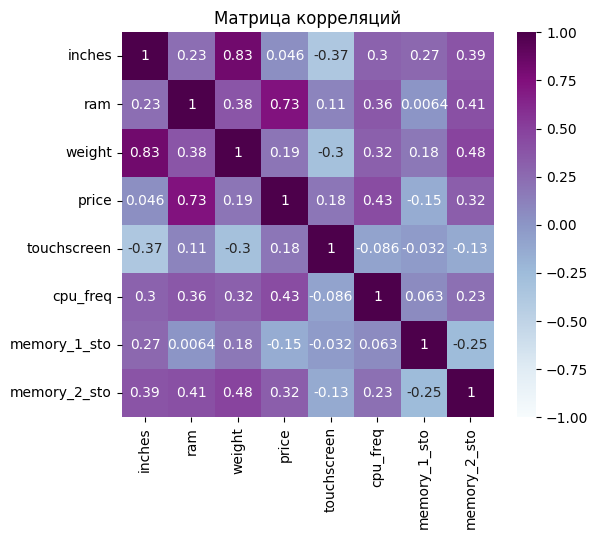

In [ ]:
laptop_model.cor_mat(data_laptop)

## Графики

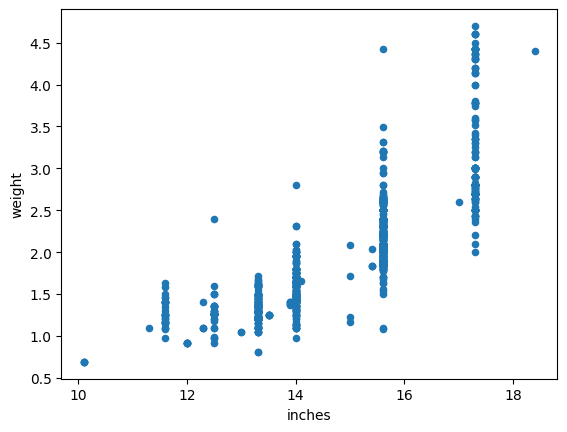

In [ ]:
data_laptop.plot.scatter(x="inches", y="weight");

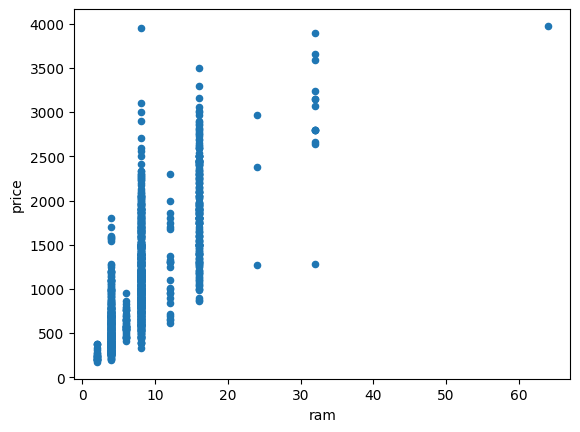

In [ ]:
data_laptop.plot.scatter(x="ram", y="price");

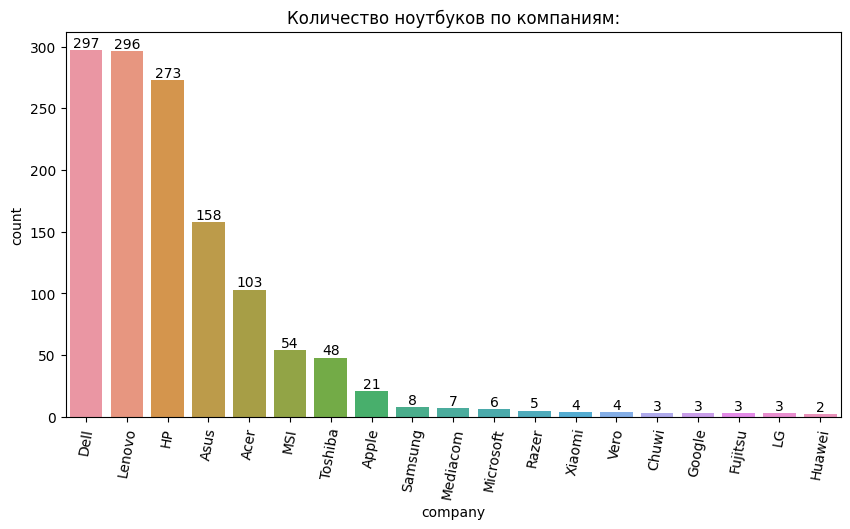

In [ ]:
# Компании с наибольшим числом ноутбуков
fig, ax  = plt.subplots(figsize=(10,5))
ax=sns.countplot(x='company', data=data_laptop, order = df['company'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
ax.bar_label(ax.containers[0])
plt.title('Количество ноутбуков по компаниям:')
plt.show()

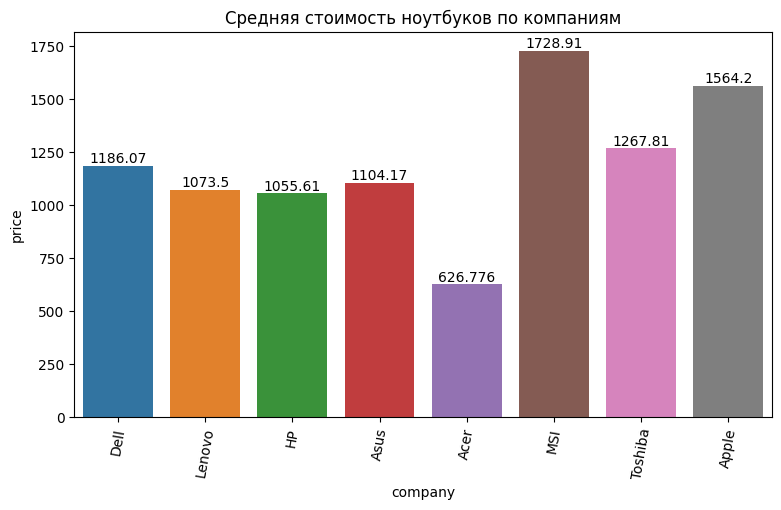

In [ ]:
plt.figure(figsize=(9,5))
ax=sns.barplot(x='company', y='price', data=df_clean[df_clean['company'].isin(df['company'].value_counts().index[:8].tolist())],
                order=df['company'].value_counts().index[:8].tolist(),
                errorbar=('ci', False))
plt.xticks(rotation=80);
ax.bar_label(ax.containers[0])
plt.title('Средняя стоимость ноутбуков по компаниям')
plt.show()

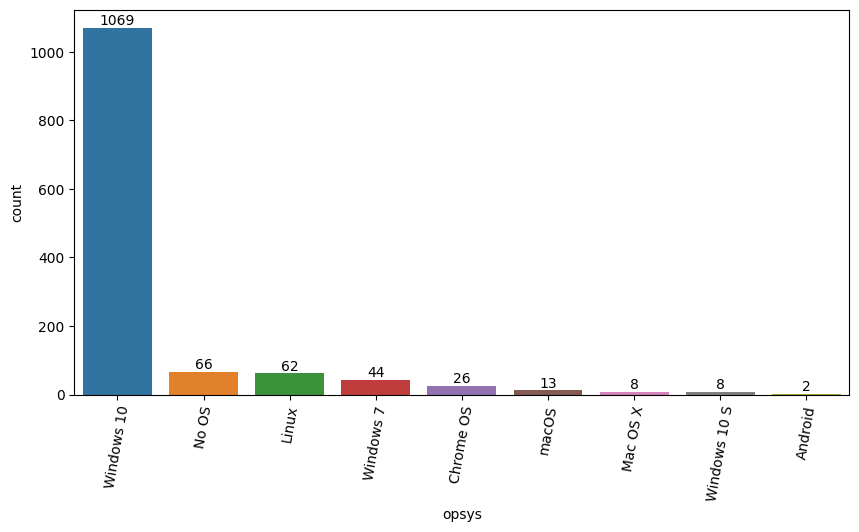

In [ ]:
fig, ax  = plt.subplots(figsize=(10,5))
ax=sns.countplot(x='opsys', data=data_laptop, order = df['opsys'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
ax.bar_label(ax.containers[0])
plt.show()

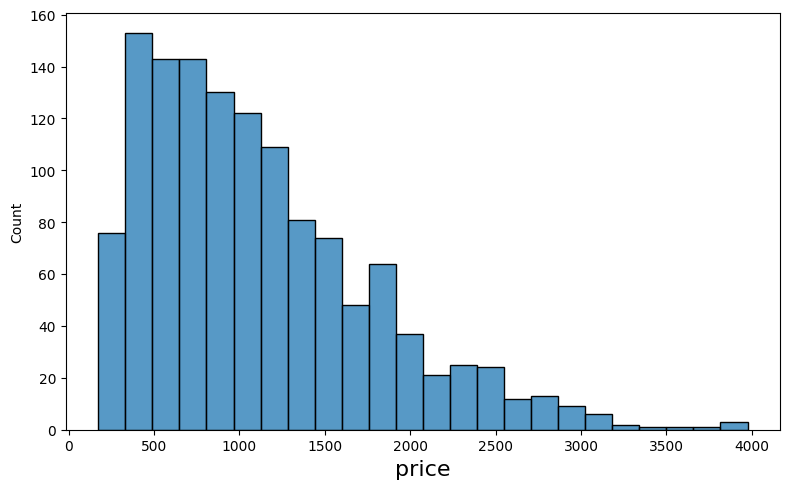

In [ ]:
laptop_model.get_plot(data_laptop, 'price')

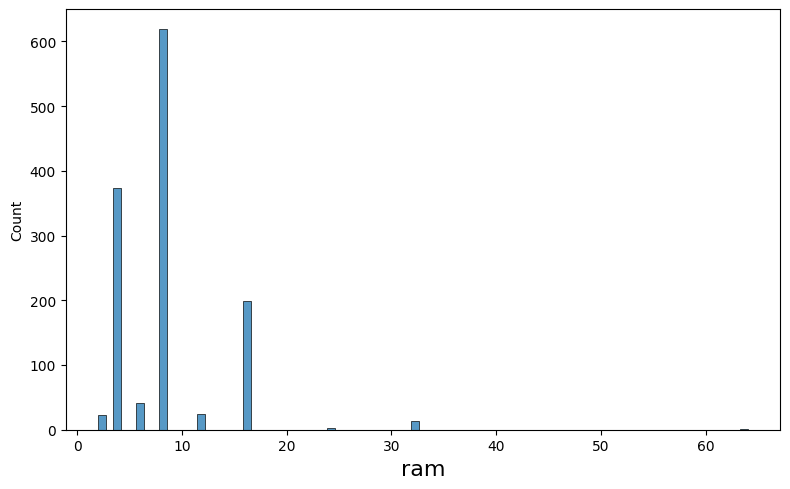

In [ ]:
laptop_model.get_plot(data_laptop, 'ram')

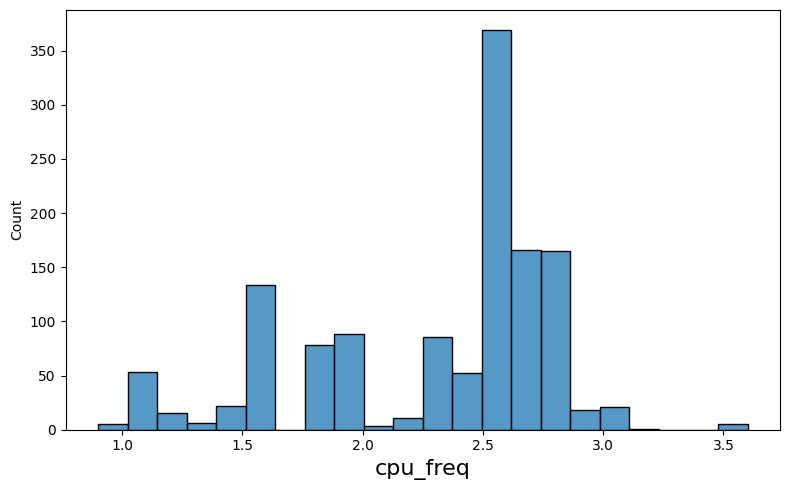

In [ ]:
laptop_model.get_plot(data_laptop, 'cpu_freq')

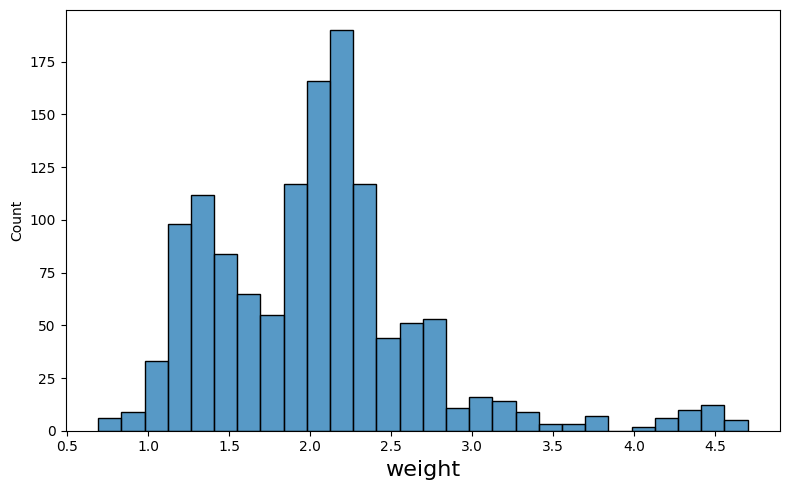

In [ ]:
laptop_model.get_plot(data_laptop, 'weight')

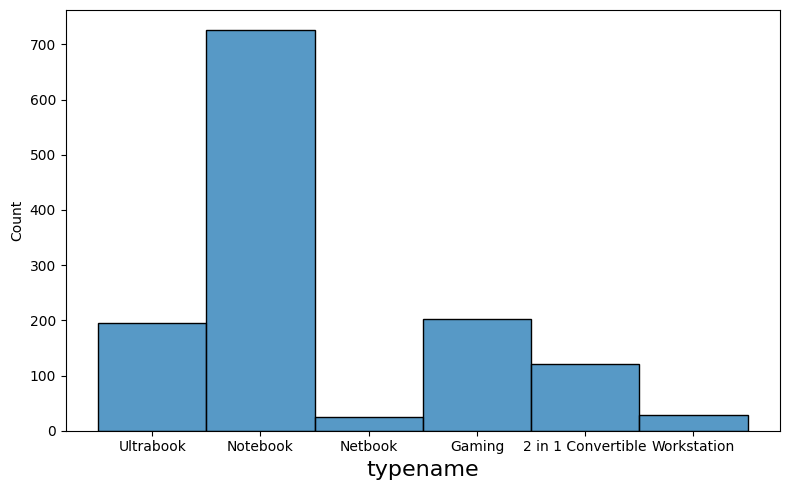

In [ ]:
laptop_model.get_plot(data_laptop, 'typename')

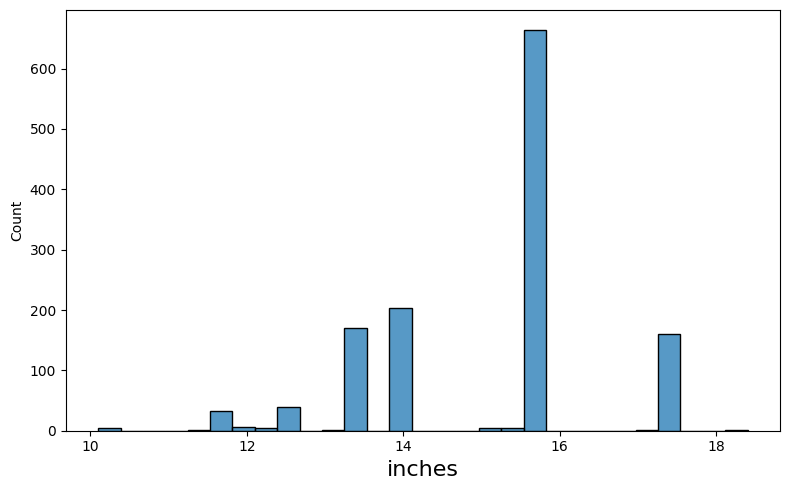

In [ ]:
laptop_model.get_plot(data_laptop, 'inches')

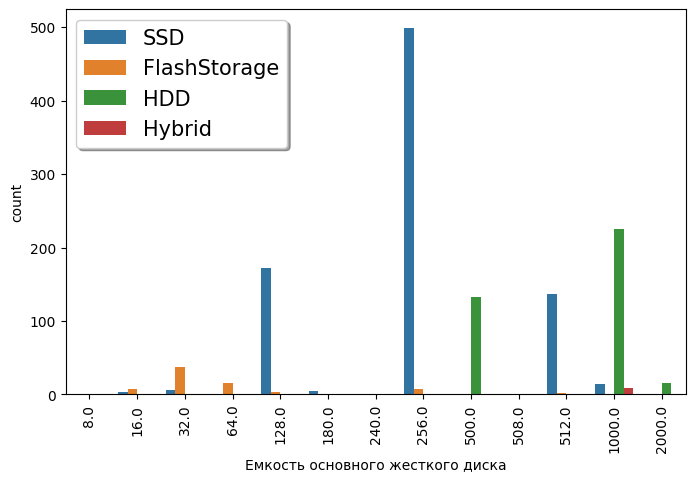

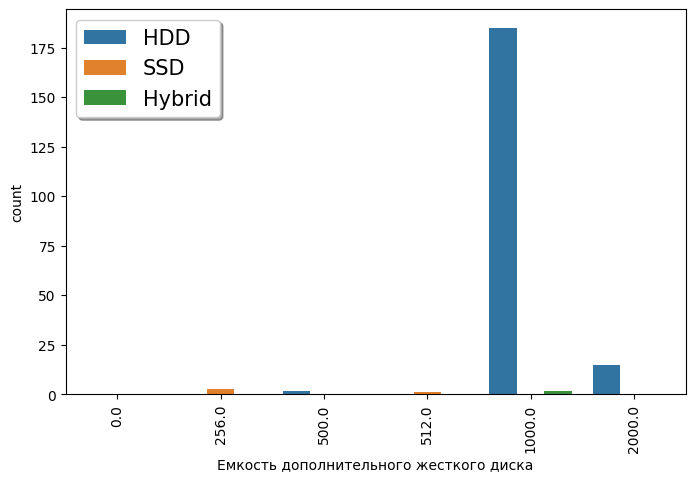

In [ ]:
laptop_model.get_memory_data(data_laptop)

## Обучение модели

<ipython-input-861-6e1476777a89>:65: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", color="red")


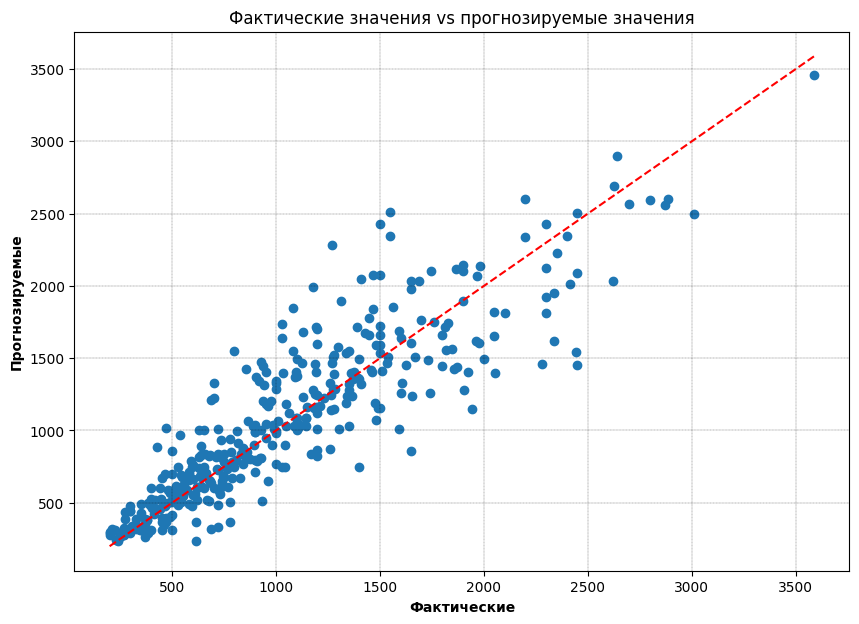

RMSE: 279.0 $ 
R2: 78.68 %


In [ ]:
# Подготовка данных
X_train, X_test, y_train, y_test = laptop_model.data_preparing(data_laptop)
# Обучение модели
laptop_model.fit(X_train, y_train)
y_pred = laptop_model.predict(X_test)
# Результаты
laptop_model.visualization(y_test, y_pred)